In [2]:
%matplotlib inline
import numpy as np
import gp_grid
import matplotlib.pyplot as plt
from gp_grid.misc import rastrigin, grid2mat, gapify_data
from time import time
from pdb import set_trace
gp_grid.debug()
to_plot = True
from sklearn.preprocessing import StandardScaler
from numpy.testing import assert_array_almost_equal
import GPy

# Test `gp_grid.models.GPGappyRegression`
## Test the Posterior Variance
TODO: also do the posterior mean check here!

In [2]:
# get the data
np.random.seed(0)
d = 2

# generate the full training set
n = 20 # number of points along each dimension
xg = [np.linspace(0,1,num=n).reshape((-1,1)),]*d
x = grid2mat(*xg)
y_full = rastrigin((x*2-1)*5.12)
y_scaler = StandardScaler().fit(y_full)
y_full = y_scaler.transform(y_full)
yg_full = y_full.reshape((n,)*d)
N = n**d

# hyperparameters to use (from nips_gappy/studies/gappiness sweep)
kern_list = [gp_grid.kern.RBF(1, lengthscale=0.0652723) for i in range(d)]
kern_list[0].variance = 166.298
noise_var = 1e-5

# randomly apply the mask to the gaps
gappiness = 0.25
gaps,y = gapify_data(y_full,gappiness)
yg = y.reshape((n,)*d)

# get the input position of the gaps and the training data
n_gaps = gaps.size
n_train = y.size-n_gaps
X = np.delete(x, gaps, axis=0) # start with all the points then remove gaps
Y = np.delete(y, gaps, axis=0) # ... same here
Xt = np.zeros((n_gaps,d))
idx = np.unravel_index(gaps,(n,)*d)
for i_d in range(d):
    Xt[:,i_d] = xg[i_d][idx[i_d],0]

# train a gpy model
mgpy = GPy.models.GPRegression(X,Y,GPy.kern.RBF(2,variance=166.298,lengthscale=0.0652723), noise_var=noise_var)
gpy_cov = mgpy.predict(Xt,full_cov=True)[1]

# train gp_grid model
m = gp_grid.models.GPGappyRegression(xg,yg,kern_list,noise_var=noise_var)
for key, value in {'iterative_formulation':'IG','preconditioner':'rank-reduced','n_eigs':300}.iteritems():
    setattr(m,key,value)
m.pcg_options['maxiter'] = 2000
m.pcg_options['tol'] = 1e-6
m.dim_noise_var = 0.
m.fit()

# compute the posterior variance
my_cov = m.predict_cov(X_new=Xt, exact=True)

# check if equal
assert_array_almost_equal(gpy_cov,my_cov,decimal=3)
print "done tests."

[ 16:30:18 ] gp_grid.kern DEBUG: Initializing RBF kernel.
[ 16:30:18 ] gp_grid.kern DEBUG: Initializing RBF kernel.
[ 16:30:18 ] GP INFO: initializing Y
[ 16:30:18 ] GP INFO: initializing inference method
[ 16:30:18 ] GP INFO: adding kernel and likelihood as parameters
[ 16:30:18 ] gp_grid.models DEBUG: Initializing GPGappyRegression model.
done tests.


## Test the Preconditioners

First get the dataset with a random gappy response vector

In [3]:
np.random.seed(0)
d = 2
n = 40
N = n**d
p = 400 # num eigvals
lengthscale = 0.05
xg = [np.linspace(0,1,num=n).reshape((-1,1)),]*d # d-dimensional grid
yg = gapify_data(np.random.normal(loc=0.0, scale=1.0, size=(N,1)), gappiness=0.5)[1].reshape((n,)*d)
y = yg.reshape((-1,1))
nominal = np.linalg.norm(y) # nominal residual (with alp = 0)
kern_list = [gp_grid.kern.RBF(1, lengthscale=lengthscale) for i in range(d)] #initialize the kernel
noise_var = 1e-6
m = gp_grid.models.GPGappyRegression(xg,yg,kern_list,noise_var=noise_var) # initialize the model
m.n_eigs = p
m.pcg_options['maxiter']     = 200000
m.pcg_options['tol']         = 1e-6
m.parameters; # set internal state

[ 16:30:22 ] gp_grid.kern DEBUG: Initializing RBF kernel.
[ 16:30:22 ] gp_grid.kern DEBUG: Initializing RBF kernel.
[ 16:30:22 ] gp_grid.models DEBUG: Initializing GPGappyRegression model.


Now, for both the FG and IG methods, check that adding a preconditioner decreases the condition number of the system of equations which needs to be solved.

Additionally, check that the method converges faster with the use of the preconditioner

In [4]:
# set up the preconditioners
m._fg_preconditioner()
m._rank_reduced_cov() # setup the rank reduced approx

for method in ['IG', 'FG']:
    # get matrix vector routines
    if method == 'IG':
        size = m.n_not_gaps
        mv = m._mv_IG
        precon_mv = m._mv_rr_cov_inv
    elif method == 'FG':
        size = m.n_gaps
        mv = m._mv_FG
        precon_mv = m._mv_rr_fg_precon
        
    # initialize matricies and compute
    nominal_mat = np.zeros((size,size))
    modified_mat = np.zeros((size,size))
    for i, e_i in enumerate(np.identity(size)):
        nominal_mat[:,i,None] = mv(e_i.reshape((-1,1)))
        modified_mat[:,i,None] = precon_mv(nominal_mat[:,i,None])
    nom_cond = np.linalg.cond(nominal_mat)
    mod_cond = np.linalg.cond(modified_mat)
    print "%s nominal cond: %.2f, modified cond: %.2f" % (method,nom_cond,mod_cond)
    print "%s factional condition number: %.3f" % (method,mod_cond/nom_cond)
    assert mod_cond/nom_cond < 1, "condition number didn't decrease"
    
    # check the time required to fit with and without precon
    times = np.zeros(2)
    for i,precon in enumerate([None, 'rank-reduced']):
        m._alpha = None
        m.preconditioner = precon
        t0 = time()
        m.fit()
        t1 = time()
        print '    time w/ %s precon = %.2f seconds' % (repr(precon),t1-t0)
        times[i] = t1-t0
    assert times[1] < times[0], "preconditioner didn't expedite convergence"

IG nominal cond: 4528191.40, modified cond: 455002.53
IG factional condition number: 0.100
    time w/ None precon = 1.83 seconds
    time w/ 'rank-reduced' precon = 0.94 seconds
FG nominal cond: 332954.73, modified cond: 97532.62
FG factional condition number: 0.293
    time w/ None precon = 1.78 seconds
    time w/ 'rank-reduced' precon = 0.90 seconds


## Test Training the Models Through the different methods

In [5]:
np.random.seed(0)
d = 2

# generate the training set
n = 25 # number of points along each dimension
N_missing = np.int32(np.floor(0.25*n**d))
xg = [np.linspace(0,1,num=n).reshape((-1,1)),]*d
x = grid2mat(*xg)
y = rastrigin((x*2-1)*5.12)
gaps = np.random.choice(y.shape[0], size=N_missing, replace=False) # randomly set some data to nan
y[gaps] = np.nan
yg = y.reshape((n,)*d)
# plt.imshow(yg,interpolation='none') # plot the training data

# generate the test set
nn = 100 # number of test points along each dimension
xxg = [np.linspace(0,1,num=nn).reshape((-1,1)),]*d
xx = grid2mat(*xxg) 
yy = rastrigin((xx*2-1)*5.12)

def plot_model(m):
    plt.figure()
    yyh = m.predict_grid(xxg) # the model prediction
    plt.subplot(1,3,1)
    plt.imshow(yg,interpolation='none')
    plt.title('training data')
    plt.subplot(1,3,2)
    plt.imshow(yyh.reshape((nn,)*d),interpolation='none')
    plt.title('prediction')
    plt.subplot(1,3,3)
    plt.imshow(yy.reshape((nn,)*d),interpolation='none')
    plt.title('exact')
    plt.show()

### Fill Gaps MLE with preconditioner

[ 16:30:30 ] gp_grid.kern DEBUG: Initializing RBF kernel.
[ 16:30:30 ] gp_grid.kern DEBUG: Initializing RBF kernel.
[ 16:30:30 ] gp_grid.models DEBUG: Initializing GPGappyRegression model.
[ 16:30:32 ] gp_grid.models INFO: Gradient check passed.
[ 16:30:32 ] gp_grid.models DEBUG: Beginning MLE to optimize hyperparameters. grad_method=adjoint
[ 16:30:39 ] gp_grid.models INFO: Function Evals: 2090. Exit status: 0
[ 16:30:39 ] gp_grid.models DEBUG: using the exact log_det for log likelihood. May be expensive!
exact log-likelihood:    -2051.87
computed log-likelihood: -2090.79
[ 16:30:39 ] gp_grid.models DEBUG: Predicting model at new points.


 /home/trefor/Documents/gp_grid/linalg.py:58: RuntimeWarning:overflow encountered in expm1


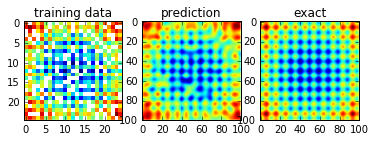

In [6]:
kern_list = [gp_grid.kern.RBF(1, lengthscale=0.05) for i in range(d)]
kern_list[0].variance = 875.
m = gp_grid.models.GPGappyRegression(xg,yg,kern_list,noise_var=1.1e-6)
m.iterative_formulation = 'FG'
m.MLE_method = 'iterative'
m.grad_method = 'adjoint'
m.preconditioner = 'rank-reduced'
m.checkgrad()
m.optimize()
m.fit()
exact_ll = m._compute_log_likelihood(parameters=m.parameters,exact_det=True) # this is the exact log_likelihood
approx_ll = m._compute_log_likelihood(parameters=m.parameters,exact_det=False)
print 'exact log-likelihood:    %g' % exact_ll
print 'computed log-likelihood: %g' % approx_ll
assert np.abs((exact_ll-approx_ll)/exact_ll) < 0.05, "log-likelihood relative error too large"
if to_plot:
    plot_model(m)

### Fill Gaps MLE

[ 16:30:40 ] gp_grid.kern DEBUG: Initializing RBF kernel.
[ 16:30:40 ] gp_grid.kern DEBUG: Initializing RBF kernel.
[ 16:30:40 ] gp_grid.models DEBUG: Initializing GPGappyRegression model.
[ 16:30:40 ] gp_grid.models INFO: Gradient check passed.
[ 16:30:40 ] gp_grid.models DEBUG: Beginning MLE to optimize hyperparameters. grad_method=adjoint
[ 16:30:42 ] gp_grid.models INFO: Function Evals: 2090. Exit status: 2
[ 16:30:42 ] gp_grid.models DEBUG: using the exact log_det for log likelihood. May be expensive!
exact log-likelihood:    -2051.88
computed log-likelihood: -2090.79
[ 16:30:42 ] gp_grid.models DEBUG: Predicting model at new points.


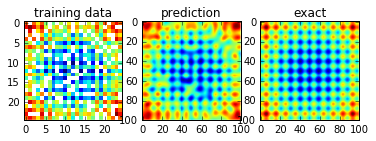

In [7]:
kern_list = [gp_grid.kern.RBF(1, lengthscale=0.05) for i in range(d)]
kern_list[0].variance = 875.
m = gp_grid.models.GPGappyRegression(xg,yg,kern_list,noise_var=1.1e-6)
m.iterative_formulation = 'FG'
m.MLE_method = 'iterative'
m.grad_method = 'adjoint'
m.preconditioner = None
m.checkgrad()
m.optimize()
m.fit()
exact_ll = m._compute_log_likelihood(parameters=m.parameters,exact_det=True) # this is the exact log_likelihood
approx_ll = m._compute_log_likelihood(parameters=m.parameters,exact_det=False)
print 'exact log-likelihood:    %g' % exact_ll
print 'computed log-likelihood: %g' % approx_ll
assert np.abs((exact_ll-approx_ll)/exact_ll) < 0.05, "log-likelihood relative error too large"
if to_plot:
    plot_model(m)

### Ignore Gaps MLE with Preconditioner

[ 16:30:43 ] gp_grid.kern DEBUG: Initializing RBF kernel.
[ 16:30:43 ] gp_grid.kern DEBUG: Initializing RBF kernel.
[ 16:30:43 ] gp_grid.models DEBUG: Initializing GPGappyRegression model.
[ 16:30:52 ] gp_grid.models INFO: Gradient check passed.
[ 16:30:52 ] gp_grid.models DEBUG: Beginning MLE to optimize hyperparameters. grad_method=adjoint
[ 16:30:59 ] gp_grid.models CRITICAL: pcg convergence to tolerance not achieved. Number of iterations: 10000
[ 16:31:06 ] gp_grid.models INFO: Function Evals: 2090. Exit status: 0
[ 16:31:06 ] gp_grid.models DEBUG: using the exact log_det for log likelihood. May be expensive!
exact log-likelihood:    -2051.87
computed log-likelihood: -2090.79
[ 16:31:06 ] gp_grid.models DEBUG: Predicting model at new points.


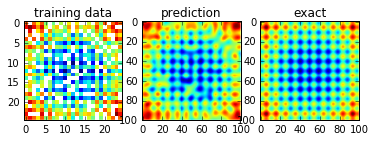

In [8]:
kern_list = [gp_grid.kern.RBF(1, lengthscale=0.05) for i in range(d)]
kern_list[0].variance = 875.
m = gp_grid.models.GPGappyRegression(xg,yg,kern_list,noise_var=1.1e-6)
m.iterative_formulation = 'IG'
m.MLE_method = 'iterative'
m.grad_method = 'adjoint'
m.preconditioner = 'rank-reduced'
m.n_eigs = 100
m.checkgrad()
m.optimize()
m.fit()
exact_ll = m._compute_log_likelihood(parameters=m.parameters,exact_det=True) # this is the exact log_likelihood
approx_ll = m._compute_log_likelihood(parameters=m.parameters,exact_det=False)
print 'exact log-likelihood:    %g' % exact_ll
print 'computed log-likelihood: %g' % approx_ll
assert np.abs((exact_ll-approx_ll)/exact_ll) < 0.05, "log-likelihood relative error too large"
if to_plot:
    plot_model(m)

### Rank-Reduced MLE

[ 16:31:07 ] gp_grid.kern DEBUG: Initializing RBF kernel.
[ 16:31:07 ] gp_grid.kern DEBUG: Initializing RBF kernel.
[ 16:31:07 ] gp_grid.models DEBUG: Initializing GPGappyRegression model.
[ 16:31:07 ] gp_grid.models INFO: Gradient check passed.
[ 16:31:07 ] gp_grid.models DEBUG: Beginning MLE to optimize hyperparameters. grad_method=finite_difference
[ 16:31:27 ] gp_grid.models INFO: Function Evals: 1754. Exit status: 0
[ 16:31:27 ] gp_grid.models DEBUG: using the exact log_det for log likelihood. May be expensive!
exact log-likelihood:    4391.05
computed log-likelihood: -1754.32
[ 16:31:27 ] gp_grid.models DEBUG: Predicting model at new points.


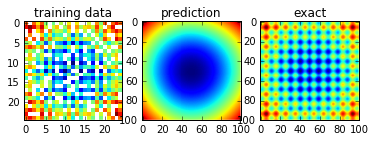

In [9]:
kern_list = [gp_grid.kern.RBF(1, lengthscale=0.05) for i in range(d)]
kern_list[0].variance = 875.
m = gp_grid.models.GPGappyRegression(xg,yg,kern_list,noise_var=1.1e-6)
m.iterative_formulation = 'IG' # this will be used for the final build
m.MLE_method = 'rank-reduced'
m.grad_method = 'finite_difference'
m.preconditioner = None # this has no effect for rank reduced
m.n_eigs = 100 # this has a strong dependency on the quality of the final result
m.checkgrad()
m.optimize()
m.fit()
exact_ll = m._compute_log_likelihood(parameters=m.parameters,exact_det=True) # this is the exact log_likelihood
approx_ll = m._compute_log_likelihood(parameters=m.parameters,exact_det=False)
print 'exact log-likelihood:    %g' % exact_ll
print 'computed log-likelihood: %g' % approx_ll
if to_plot:
    plot_model(m)

### Penalize Gaps MLE Formulation with Preconditioner

[ 16:31:28 ] gp_grid.kern DEBUG: Initializing RBF kernel.
[ 16:31:28 ] gp_grid.kern DEBUG: Initializing RBF kernel.
[ 16:31:28 ] gp_grid.models DEBUG: Initializing GPGappyRegression model.
[ 16:31:29 ] gp_grid.models INFO: Gradient check passed.
[ 16:31:29 ] gp_grid.models DEBUG: Beginning MLE to optimize hyperparameters. grad_method=adjoint
[ 16:31:31 ] gp_grid.models CRITICAL: pcg convergence to tolerance not achieved. Number of iterations: 10000
[ 16:31:32 ] gp_grid.models CRITICAL: pcg convergence to tolerance not achieved. Number of iterations: 10000
[ 16:31:34 ] gp_grid.models INFO: Function Evals: 2102. Exit status: 0
[ 16:31:35 ] gp_grid.models DEBUG: using the exact log_det for log likelihood. May be expensive!
exact log-likelihood:    -2063.91
computed log-likelihood: -2102.61
[ 16:31:35 ] gp_grid.models DEBUG: Predicting model at new points.


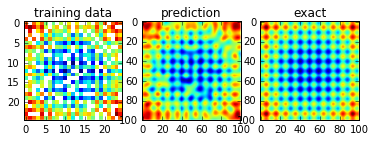

In [10]:
kern_list = [gp_grid.kern.RBF(1, lengthscale=0.05) for i in range(d)]
kern_list[0].variance = 875.
m = gp_grid.models.GPGappyRegression(xg,yg,kern_list,noise_var=1.1e-6)
m.iterative_formulation = 'PG' 
m.MLE_method = 'iterative'
m.grad_method = 'adjoint'
m.preconditioner = 'wilson'
m.checkgrad()
m.optimize()
m.fit()
exact_ll = m._compute_log_likelihood(parameters=m.parameters,exact_det=True) # this is the exact log_likelihood
approx_ll = m._compute_log_likelihood(parameters=m.parameters,exact_det=False)
print 'exact log-likelihood:    %g' % exact_ll
print 'computed log-likelihood: %g' % approx_ll
assert np.abs((exact_ll-approx_ll)/exact_ll) < 0.05, "log-likelihood relative error too large"
if to_plot:
    plot_model(m)